In [1]:
# Author: Ayush Oturkar
# Topic: Predict Future Sales

# Data Manipulation packages
import pandas as pd
import numpy as np
import os

# Data Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# %#matplotlib inline

from itertools import product

# For proper display of all columns
from IPython.display import display

pd.options.display.max_columns = None

# Import warnings
import warnings

warnings.filterwarnings("ignore")

# Sklearn required packages
from sklearn.preprocessing import LabelEncoder

# Import all the modelling packages
import xgboost as xgb
import lightgbm as lgb

import gc

# Deep Learning modules

# Utility Functions

In [2]:
# Funtion to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data


def get_boxplots(train_data):
    # Extract numerical columns
    numeric_columns = list(train_data.select_dtypes(include=['number']).columns)

    # Set up subplots
    num_plots = len(numeric_columns)
    num_rows = (num_plots // 2) + (num_plots % 2)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 2 * num_rows))

    # Helper function to format column names
    def format_column_name(column_name):
        return column_name.replace("_", " ").capitalize()

    # Plot box plots for each numeric column
    for idx, column in enumerate(numeric_columns):
        row = idx // 2
        col = idx % 2

        try:
            sns.boxplot(train_data[column], ax=axes[row, col], color="red")
            axes[row, col].set_xlabel(format_column_name(column))
        except Exception as e:
            # Handle exceptions, such as when there are not enough subplots for all numeric columns
            print(f"Error plotting {column}: {e}")

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

# Loading the Dataset

In [3]:
# Provide the data folder path
folder_path = "../data"

# Loading the datasets
items = pd.read_csv(os.path.join(folder_path, "items.csv"))
shops = pd.read_csv(os.path.join(folder_path, "shops.csv"))
item_cats = pd.read_csv(os.path.join(folder_path, "item_categories.csv"))
train = pd.read_csv(os.path.join(folder_path, "sales_train.csv"))

# Setting index to ID to avoid droping it later
test = pd.read_csv(os.path.join(folder_path, "test.csv")).set_index("ID")

# Creating a data dictionary for later usage -- ***Move it somewhere else**
train_data_dict = {"items": items, "shops": shops, "cats": item_cats, "train": train}

In [4]:
# Taking a look at snap of data
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


**date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33** 
- Important variable for forecasting

In [8]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


**Objective: To forecast the sales for these shops and products for November 2015.**

# Data Cleaning & Pre-Processing

In [9]:
# Lets check the missing
for df, i in train_data_dict.items():
    print(
        "\n===={} data missing value count:====\n{}".format(
            df.upper(), missing_val_check(i)
        )
    )


====ITEMS data missing value count:====
                  Total  Percent(%)
item_name             0         0.0
item_id               0         0.0
item_category_id      0         0.0

====SHOPS data missing value count:====
           Total  Percent(%)
shop_name      0         0.0
shop_id        0         0.0

====CATS data missing value count:====
                    Total  Percent(%)
item_category_name      0         0.0
item_category_id        0         0.0

====TRAIN data missing value count:====
                Total  Percent(%)
date                0         0.0
date_block_num      0         0.0
shop_id             0         0.0
item_id             0         0.0
item_price          0         0.0
item_cnt_day        0         0.0


In [10]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


**Check for outliers in the present numeric features**

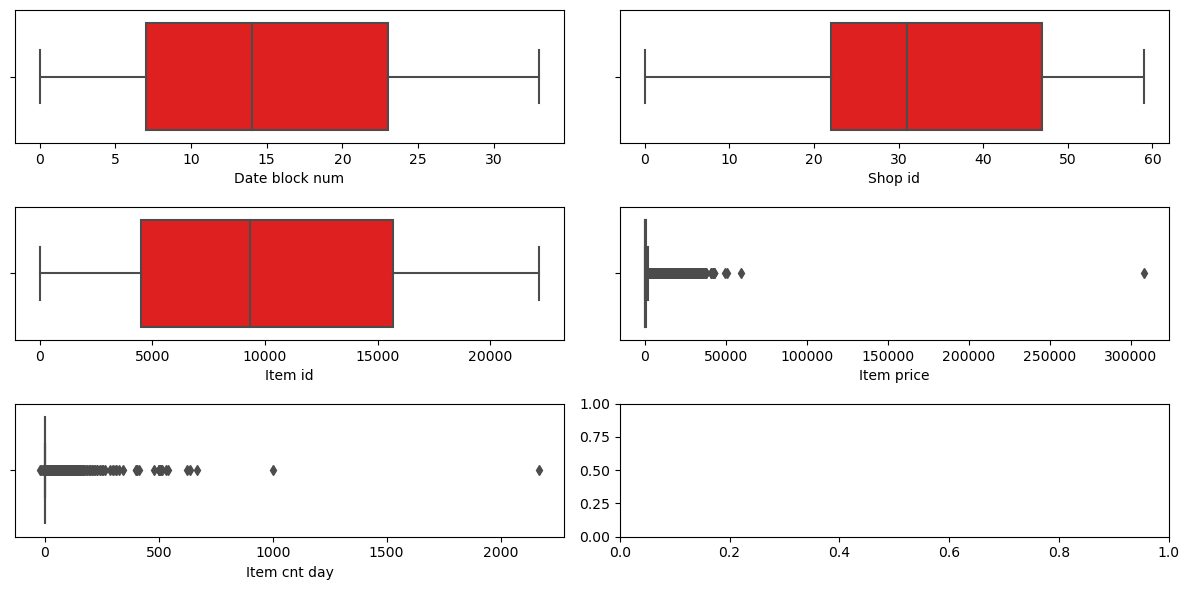

In [11]:
get_boxplots(train)

**Outlier Treatment for Enhanced Data Integrity**

Visual analysis revealed outliers within the item price and item cnt day features. To maintain data integrity and model accuracy, these outliers were addressed through a multi-pronged approach:

**Item Price:**

- Item Proce exceeding a benchmark of 50,000 will be removed based on visual observations of high price concentration.
- A minimum price threshold of 0 should be applied to ensure realistic product pricing.

**Target Variable:**

- Outliers surpassing 500 will excluded, aligning with observations of value concentration and instruction-provided clipping range.
- Subsequent clipping between 0 and 20 will be implemented to focus model training within this specified range, promoting accurate predictions.

**Trend Analysis Prior to Clipping:**

- Trend analysis was conducted before final clipping to glean potential insights from outlier patterns and assess their genuineness.

**Rationale:**

- Outlier removal and clipping safeguard model robustness and prevent undue influence from atypical values.
- Aligning feature ranges with known business constraints and expected value distributions bolsters model accuracy and interpretability.
- Trend analysis preceding clipping safeguards against premature removal of potentially informative data points.

In [12]:
# Treatment as stated
train = train.loc[
    (train["item_price"] > 0)
    & (train["item_price"] < 50000)
    & (train["item_cnt_day"] < 500)
]

gc.collect()

16467

In [13]:
print(shops.head())
print("\n\n", item_cats.head())
print("\n\n", items.head())

# I saw the data hence for the clean code checking if total row count = total unique item names
print(
    "\n\n Note: Total rows in items data {} and total unique item_names {}".format(
        items.shape[0], len(items["item_name"].unique())
    )
)

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


                                            item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2        

In [14]:
# Splitting shop name to get the city name
shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
shops["city"] = shops["city"].replace("!", "", regex=True)

# Label encoding so that it is more readable
shops["city_code"] = LabelEncoder().fit_transform(shops["city"])
shops.drop(["city"], axis=1, inplace=True)
shops.drop(["shop_name"], axis=1, inplace=True)

# Splitting category name to get the item type.
item_cats["item_cat_split"] = item_cats["item_category_name"].str.split("-")
item_cats["type"] = item_cats["item_cat_split"].map(lambda x: x[0].strip())
item_cats["type_code"] = LabelEncoder().fit_transform(item_cats["type"])

# Splitting category name to get the item type.
item_cats["subcat"] = item_cats["item_cat_split"].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)
item_cats["subcat_code"] = LabelEncoder().fit_transform(item_cats["subcat"])
item_cats = item_cats[["item_category_id", "type_code", "subcat_code"]]

# Dropping item names from items df as we discussed
# Create the date the product was first sold as a feature
items["first_sale_date"] = train.groupby("item_id").agg({"date_block_num": "min"})[
    "date_block_num"
]
# Refine null values in items table
items = items.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
items.drop(["item_name"], axis=1, inplace=True)

gc.collect()

34

**Merging suppliment data to train and test**

In [15]:
# Merge the items, shops and category data to train
train = (
    train.merge(items, on="item_id", how="left")
    .merge(shops, on="shop_id", how="left")
    .merge(item_cats, on="item_category_id", how="left")
)

# Merge the items, shops and category data to train
test = (
    test.merge(items, on="item_id", how="left")
    .merge(shops, on="shop_id", how="left")
    .merge(item_cats, on="item_category_id", how="left")
)

**Lets quickly look at our test data and see what additional item shop pairs we have.**

In [16]:
# Creating a test dummy so that we dont make any changes in test data
test_dummy = test.copy()
test_dummy["shp_itm"] = (
    test_dummy["shop_id"].astype(str) + "_" + test_dummy["item_id"].astype(str)
)
test_shp_itm_ls = list(test_dummy["shp_itm"].unique())

train["shp_itm"] = train["shop_id"].astype(str) + "_" + train["item_id"].astype(str)
trn_shp_itm_ls = list(train["shp_itm"].unique())

print("Total unique shop and item combination in the train data :", len(trn_shp_itm_ls))
print("Total unique shop and item combination in the test data:", len(test_shp_itm_ls))
print(
    "Any new shop item sales needs to be predicted:",
    str(len(list(set(test_shp_itm_ls) - set(trn_shp_itm_ls))) > 0),
)
print(
    "Total new shop item combination in the test data",
    str(len(list(set(test_shp_itm_ls) - set(trn_shp_itm_ls)))),
)

Total unique shop and item combination in the train data : 424121
Total unique shop and item combination in the test data: 214200
Any new shop item sales needs to be predicted: True
Total new shop item combination in the test data 102797


**Information regarding the Test Set**
- In the test set, there are new item pairs added over 34 months, resulting in 102,797 unique combinations.
- For most items in the test set, the target value should be zero, as they have not been sold before.

**Strategy**
- The strategy is to calculate monthly sales in the training set and extend it with zero sales for each unique pair within the month.
- This approach ensures that the training data mimics the structure of the test data.
- To achieve this, we need to create missing records for each month, shop, and item combination in the dataset.
- The sales values for these missing records should be replaced with 0 to reflect no sales.
- The goal is to mimic the behavior of the test data, where many item pairs have zero sales.

**Grouping on month level as our we need to predict next month total sales**

In [17]:
# Group by month in this case "date_block_num" and aggregate features.
train_grp = train.groupby(
    [
        "date_block_num",
        "shop_id",
        "item_category_id",
        "item_id",
        "city_code",
        "type_code",
        "subcat_code",
    ],
    as_index=False,
)
train_monthly = train_grp.agg(
    {"item_price": "mean", "item_cnt_day": ["sum", "mean", "count"]}
).reset_index(drop="True")

# Rename the columns
train_monthly.columns = [
    "date_block_num",
    "shop_id",
    "item_category_id",
    "item_id",
    "city_code",
    "type_code",
    "subcat_code",
    "item_price",
    "item_cnt",
    "mean_item_cnt",
    "transactions",
]

# Update the test
test["item_cnt"] = 0
test["date_block_num"] = 34
cols = [
    "shop_id",
    "item_id",
    "date_block_num",
    "item_category_id",
    "city_code",
    "type_code",
    "subcat_code",
    "first_sale_date",
]
train_monthly = pd.concat(
    [train_monthly, test], ignore_index=True, sort=False, keys=cols
)

**Now lets roll this data to monthly level for analysing trends**

In [18]:
# Extract time based features.
train_monthly["year"] = train_monthly["date_block_num"].apply(
    lambda x: ((x // 12) + 2013)
)
train_monthly["month"] = train_monthly["date_block_num"].apply(lambda x: (x % 12))

# Exploratory Data Analysis

In [19]:
# Lets create a revenue feature to check certain trends in comparison to
train_monthly["revenue"] = train_monthly["item_price"] * train_monthly["item_cnt"]

In [20]:
import seaborn as sns

def perform_eda(target="item_cnt"):
    if target == "item_cnt":
        target_name = "Qty"
    elif target == "revenue":
        target_name = "Revenue"

    # Monthly quantity plot
    ts_qty = train_monthly.groupby(["date_block_num"])[target].sum()
    ts_qty.astype("float")
    
    # Monthly average item price plot
    ts_price = train.groupby(["date_block_num"])["item_price"].mean()
    ts_price.astype("float")

    # Create a subplot with two y-axes
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plotting quantity on the first y-axis
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Sales", color="tab:blue")
    ax1.plot(ts_qty, color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Creating a second y-axis for average item price
    ax2 = ax1.twinx()
    ax2.set_ylabel("Average Item Price", color="tab:orange")
    ax2.plot(ts_price, color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    plt.title(f"Monthly total {target_name} and Average Item Price")
    plt.show()

    # Lets group this data to
    month_mean = train_monthly.groupby(["month"], as_index=False)[target].mean()
    month_sum = train_monthly.groupby(["month"], as_index=False)[target].sum()

    category_mean = train_monthly.groupby(["item_category_id"], as_index=False)[
        target
    ].mean()
    category_sum = train_monthly.groupby(["item_category_id"], as_index=False)[
        target
    ].sum()

    subcategory_mean = train_monthly.groupby(["subcat_code"], as_index=False)[
        target
    ].mean()
    subcategory_sum = train_monthly.groupby(["subcat_code"], as_index=False)[
        target
    ].sum()

    item_type_mean = train_monthly.groupby(["type_code"], as_index=False)[target].mean()
    item_type_sum = train_monthly.groupby(["type_code"], as_index=False)[target].sum()

    city_mean = train_monthly.groupby(["type_code"], as_index=False)[target].mean()
    city_sum = train_monthly.groupby(["type_code"], as_index=False)[target].sum()

    shop_mean = train_monthly.groupby(["shop_id"], as_index=False)[target].mean()
    shop_sum = train_monthly.groupby(["shop_id"], as_index=False)[target].sum()

    f, axes = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
    sns.lineplot(x="month", y=target, data=month_mean, ax=axes[0]).set_title(
        f"Year-Month level {target_name} mean - Trend"
    )
    sns.lineplot(x="month", y=target, data=month_sum, ax=axes[1]).set_title(
        f"Year-Month level {target_name} sum - Trend"
    )
    plt.show()

    f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
    sns.barplot(
        x="item_category_id", y=target, data=category_mean, ax=axes[0]
    ).set_title(f"{target_name} Monthly mean")
    sns.barplot(
        x="item_category_id", y=target, data=category_sum, ax=axes[1]
    ).set_title(f"{target_name} Monthly sum")
    plt.show()

    f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
    sns.barplot(x="shop_id", y=target, data=shop_mean, ax=axes[0]).set_title(
        f"{target_name} Monthly mean at shop level"
    )
    sns.barplot(x="shop_id", y=target, data=shop_sum, ax=axes[1]).set_title(
        f"{target_name} Monthly sum at shop level"
    )
    plt.show()

    # Plotting price vs item qty sales
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=train_monthly, x="item_price", y=target)
    plt.xlabel("Products average price")
    plt.ylabel(f"Product sales {target_name}")

    return (
        month_mean,
        month_sum,
        category_mean,
        category_sum,
        subcategory_mean,
        subcategory_sum,
        item_type_mean,
        item_type_sum,
        city_mean,
        city_sum,
        shop_mean,
        shop_sum,
    )

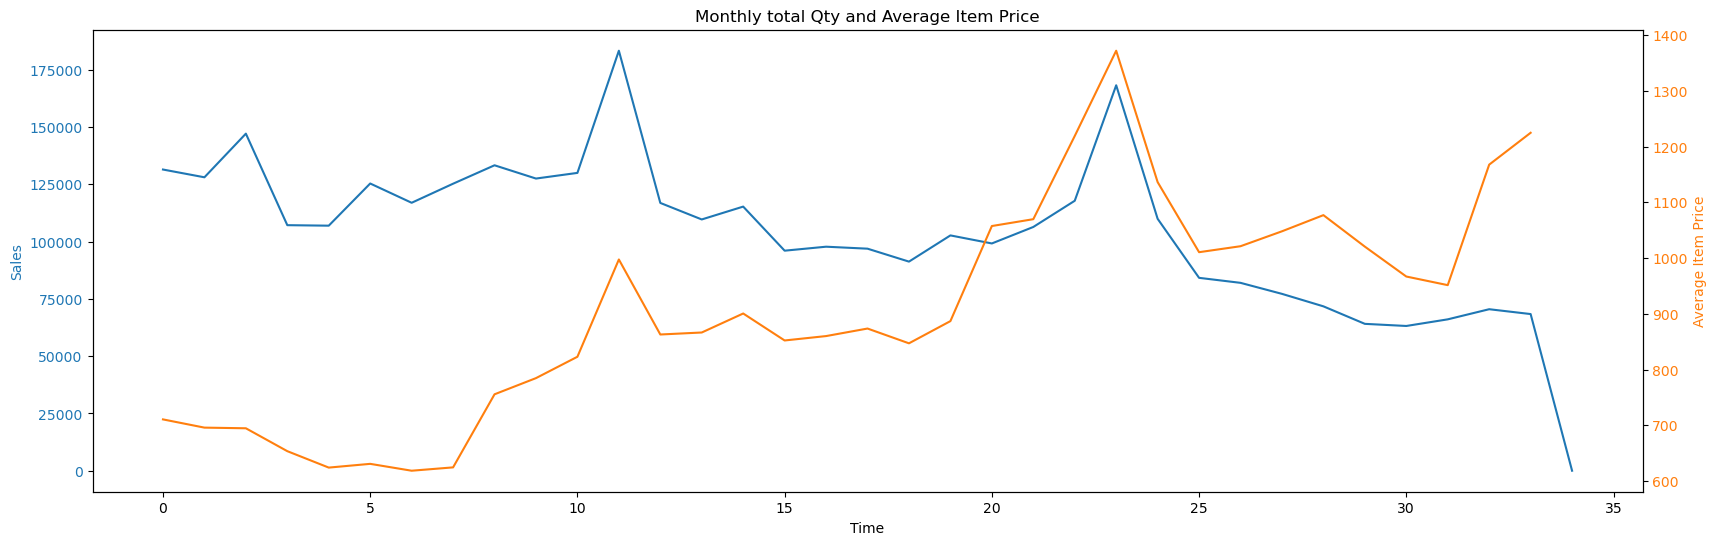

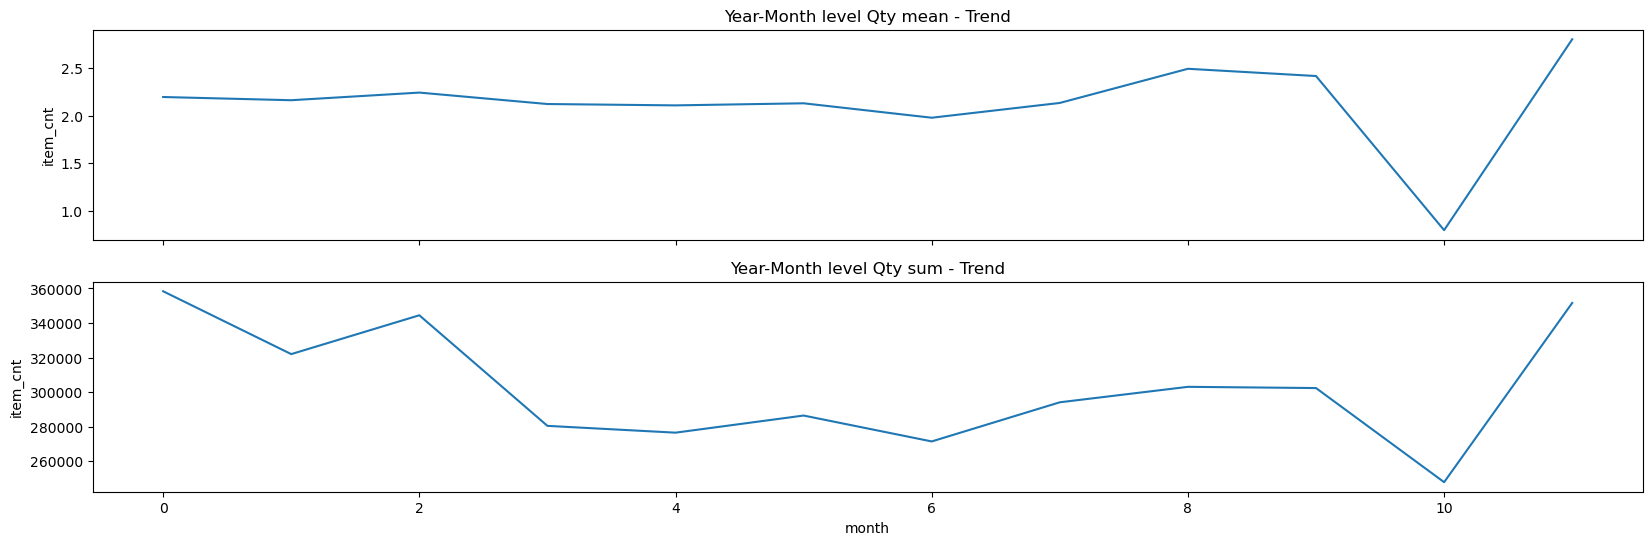

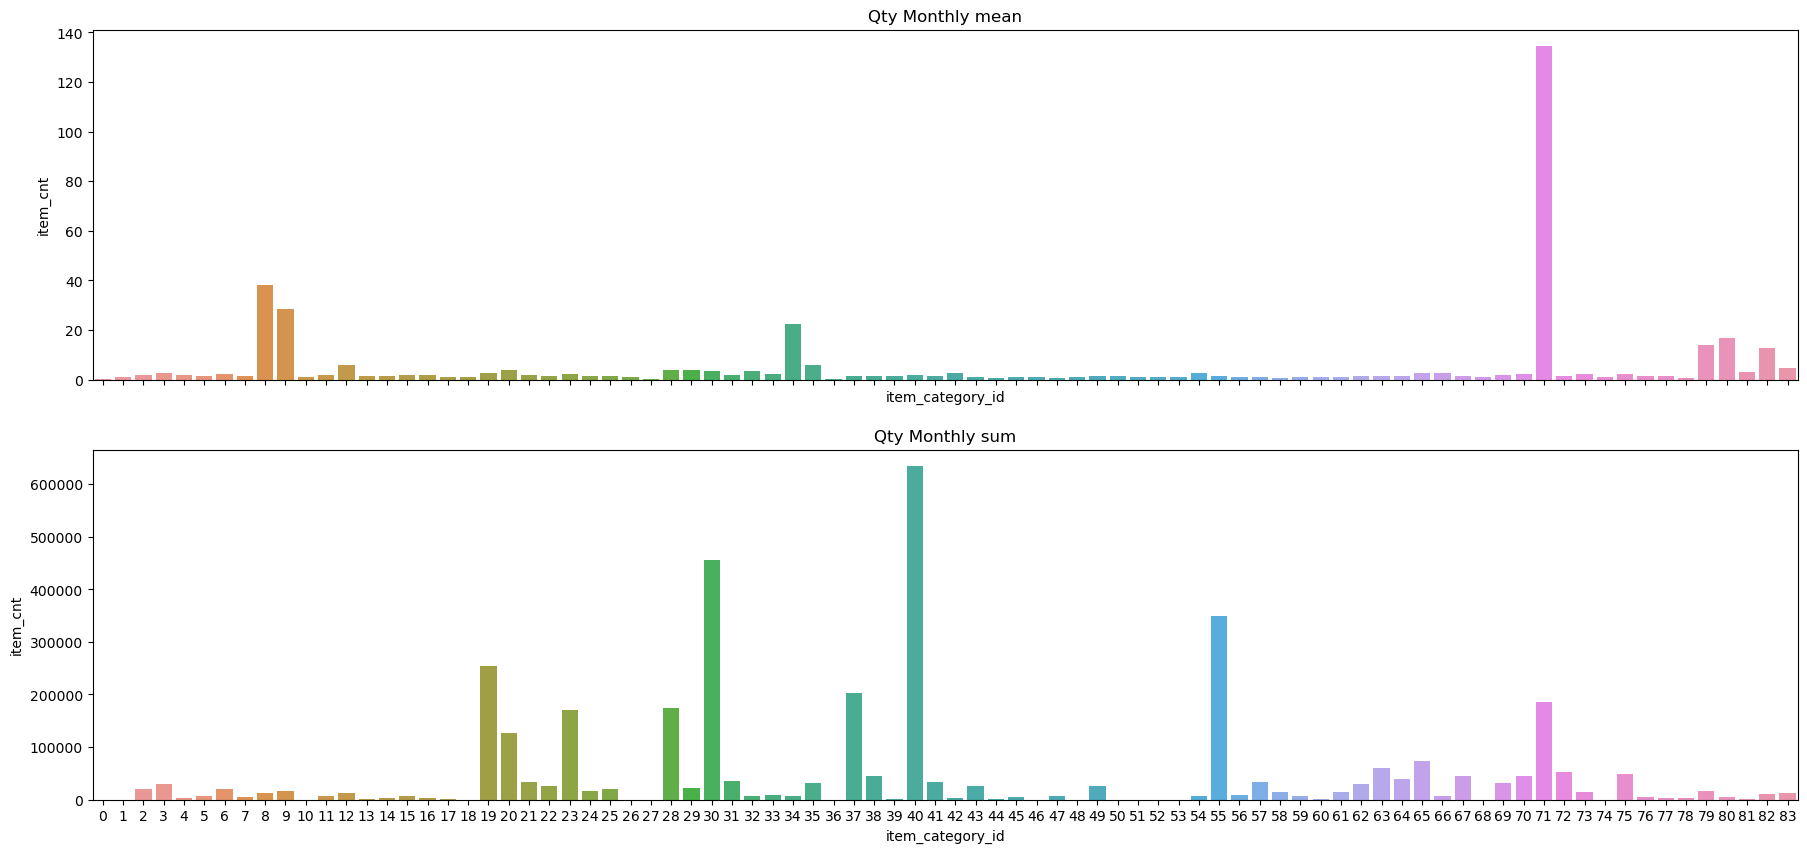

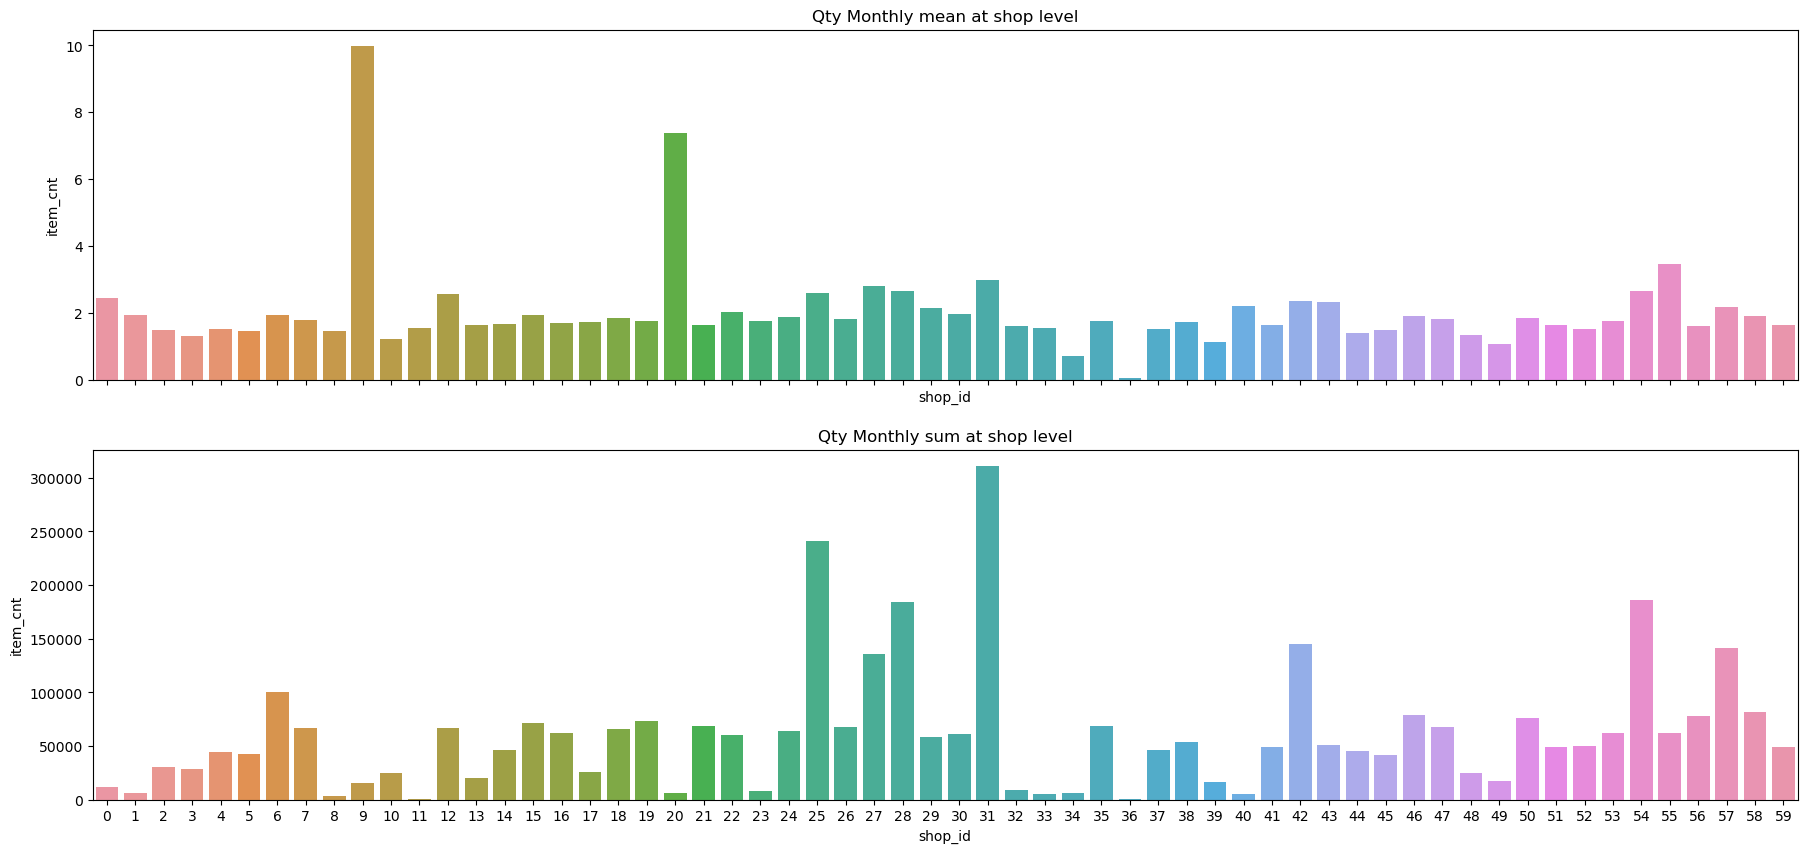

35074

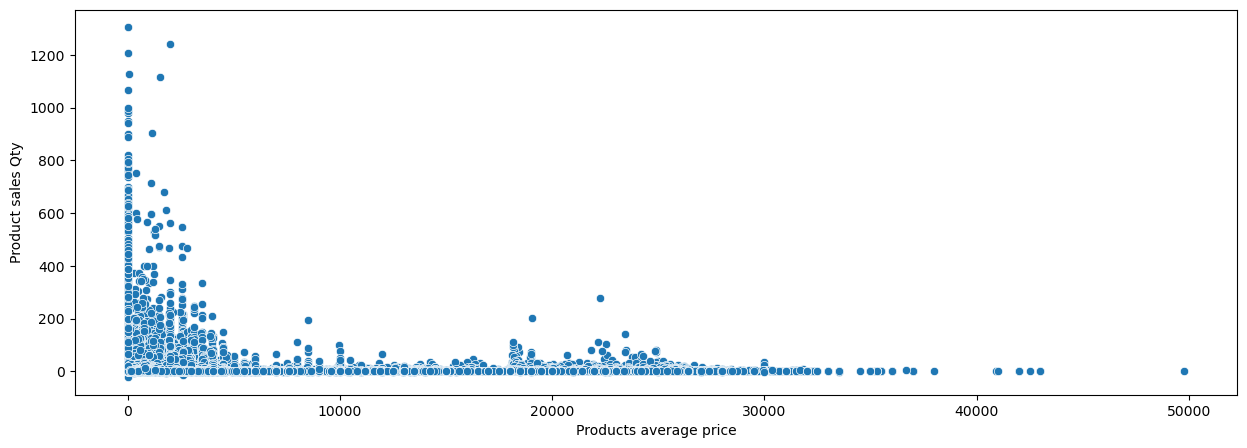

In [21]:
it_cnt = perform_eda(target="item_cnt")
del it_cnt
gc.collect()

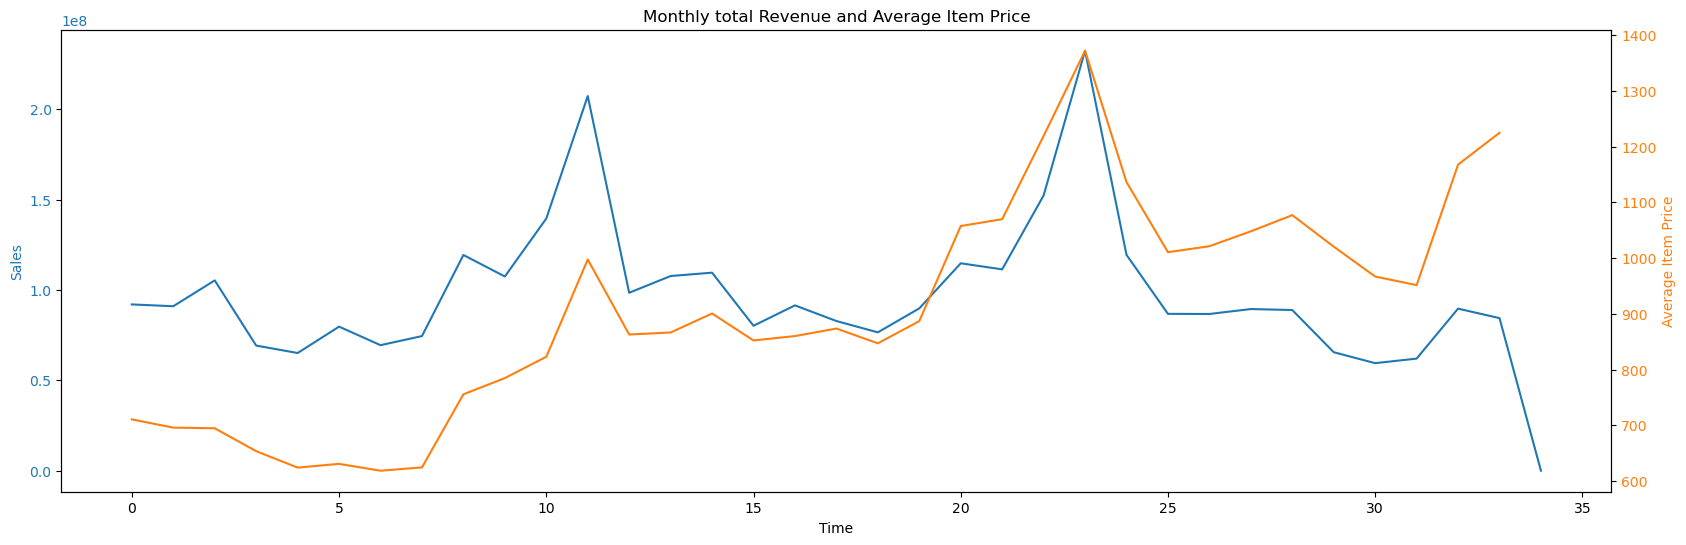

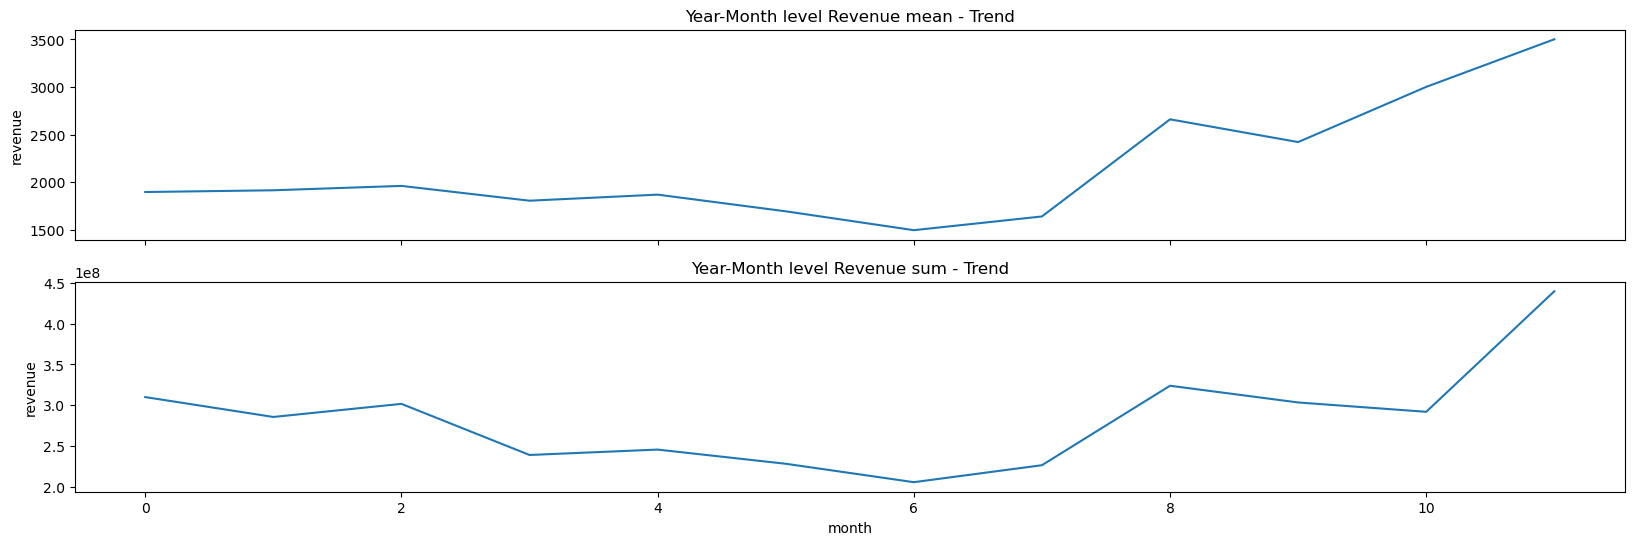

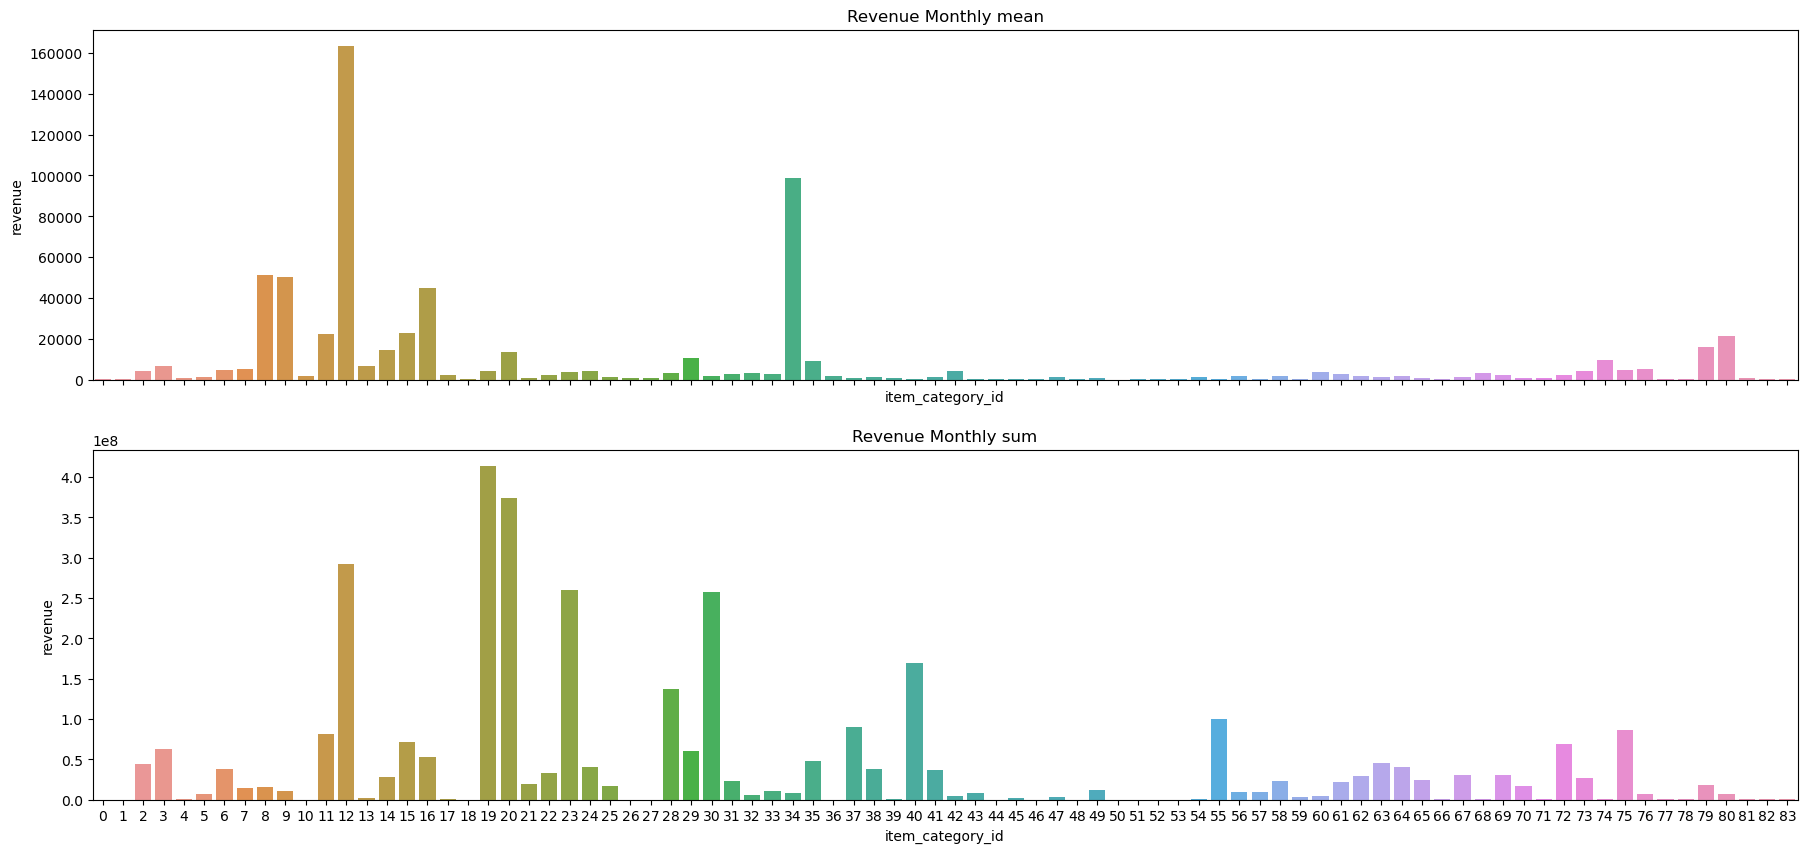

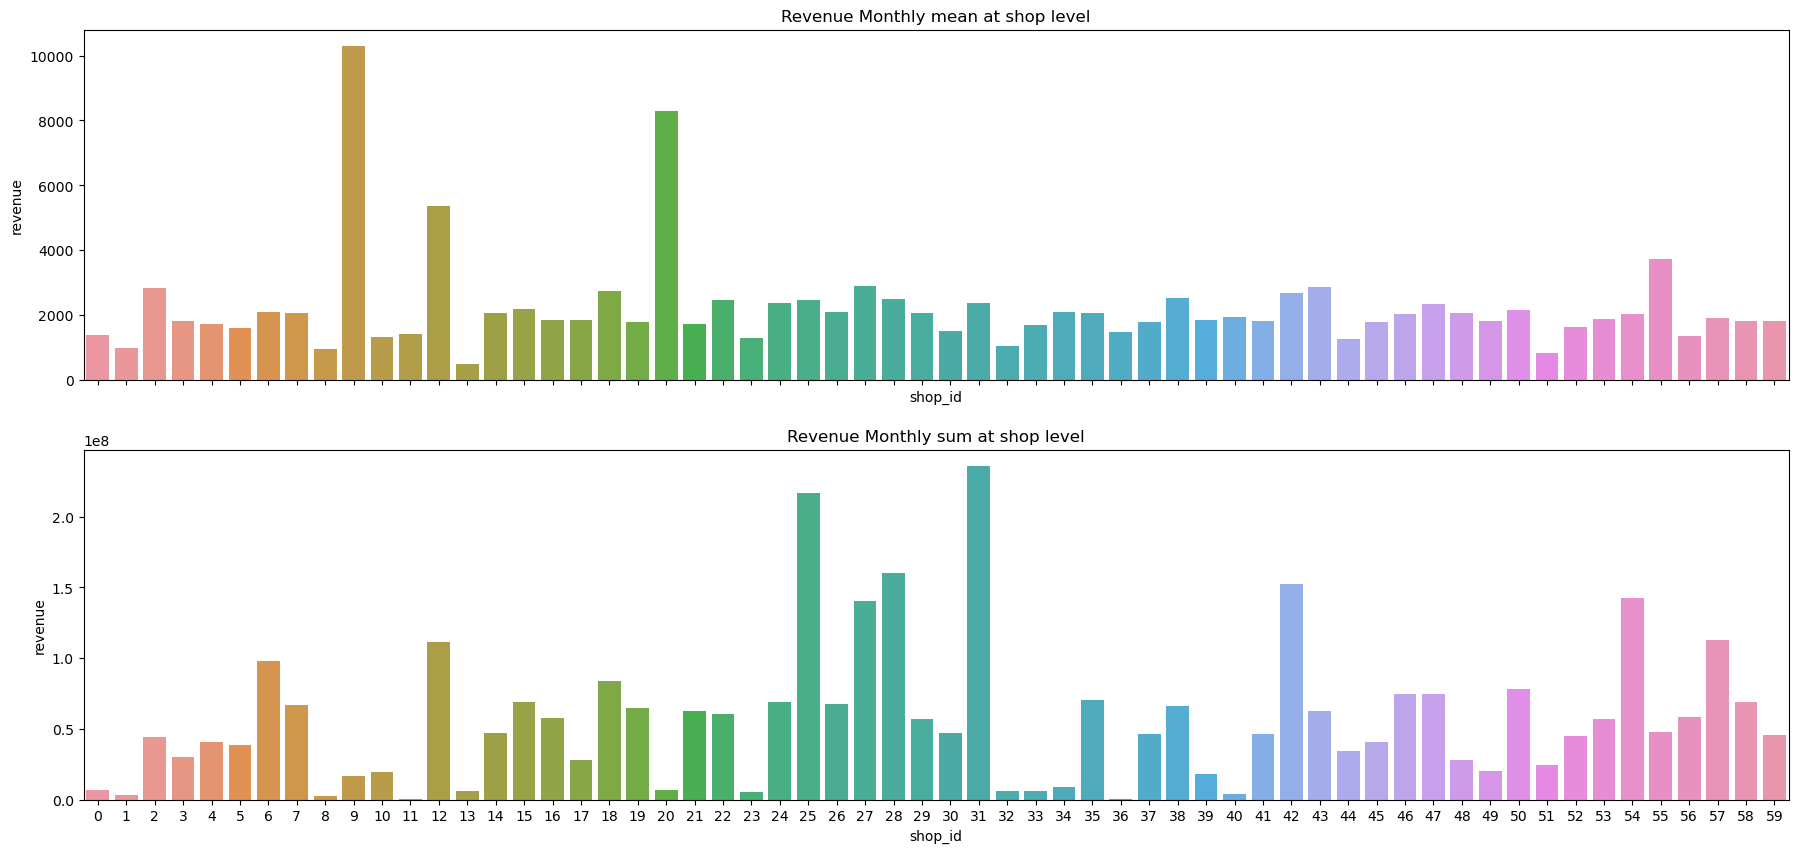

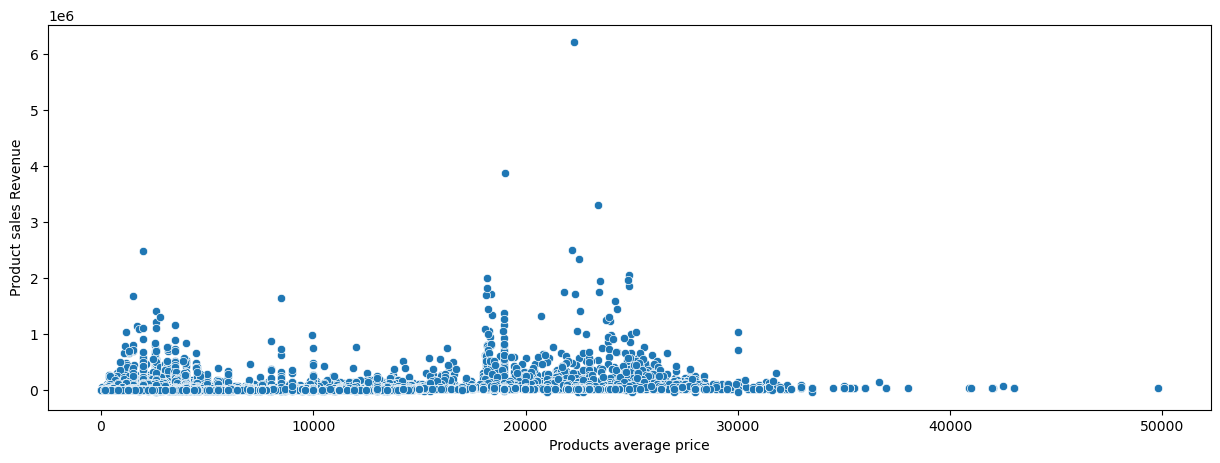

In [22]:
rev = perform_eda(target="revenue")

**Key Insights:**

1. The analysis reveals a concentration of higher quantity sales for products with lower average prices. However, it's crucial to investigate whether these products generate the highest revenue.

2. The primary contributors to revenue appear to be concentrated in the price range of approximately 18,000 to 25,000.

3. Noteworthy disparities exist among shops, with some exhibiting significantly higher sales while others experience lower sales.

4. Both revenue and quantity demonstrate an upward trend over time.

5. There is an observable pattern of average prices gradually increasing over a certain period.